In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from IPython.display import Image, display
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
from sklearn.metrics import r2_score
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import OrdinalEncoder

# Reading the files

In [3]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

train_df = pd.merge(train_df,stores_df,how='left',on='store_nbr')
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [4]:
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
oil_df['date'] = pd.to_datetime(oil_df['date'])


# Oil Preprocessing

In the below cells we preprocess oil prices. There are few missing values and also missing date entries in the oils.csv when compared to the train.csv dates. We extract the dates from the train.csv and join it with oils.

In [5]:
print(len(train_df.date.unique()) , len(oil_df.date.unique()))

dates_df = pd.DataFrame(train_df.date.unique(),columns=['date'])
dates_df['date'] = pd.to_datetime(dates_df['date'])
oil_df = pd.merge(dates_df, oil_df, how="left", on="date")
oil_df = oil_df.set_index('date')
oil_df.shape

1684 1218


(1684, 1)

In [6]:
print(oil_df.query('dcoilwtico != dcoilwtico'))
print(oil_df.isnull().sum())
print(oil_df.describe())

            dcoilwtico
date                  
2013-01-01         NaN
2013-01-05         NaN
2013-01-06         NaN
2013-01-12         NaN
2013-01-13         NaN
...                ...
2017-07-30         NaN
2017-08-05         NaN
2017-08-06         NaN
2017-08-12         NaN
2017-08-13         NaN

[521 rows x 1 columns]
dcoilwtico    521
dtype: int64
        dcoilwtico
count  1163.000000
mean     67.925589
std      25.677366
min      26.190000
25%      46.390000
50%      53.330000
75%      95.790000
max     110.620000


In [7]:
import plotly.express as px

fig = px.line(oil_df, x = oil_df.index, y ='dcoilwtico', title='Plot slider for oil prices')
fig.update_xaxes(
    rangeslider_visible = True,
)
fig.show()

For filling the missing oil values we have to find how the values at entry t is correlated with previous entries so we make correlation plots of oil prices at time t with t-n 

In [8]:
oil_na = oil_df.copy()
oil_na.dropna()

,dcoilwtico
date,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
2013-01-08,93.21
...,...
2017-08-09,49.59
2017-08-10,48.54
2017-08-11,48.81


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

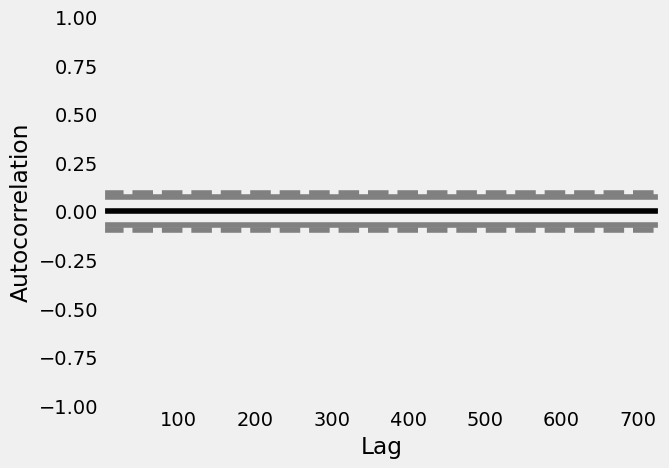

In [9]:
pd.plotting.autocorrelation_plot(oil_na['2015':'2016']['dcoilwtico'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

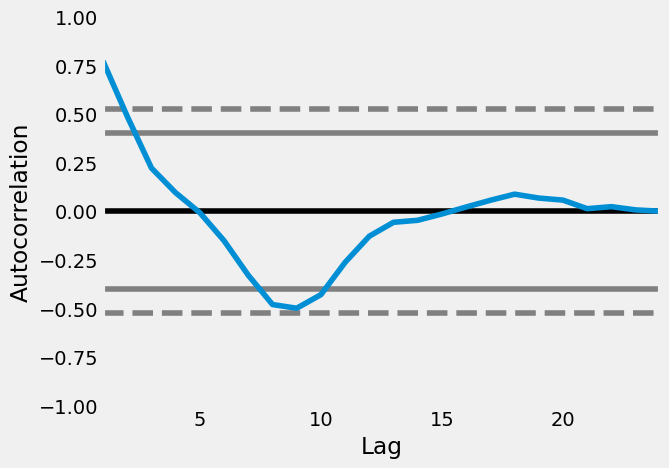

In [10]:
pd.plotting.autocorrelation_plot(oil_df['2015':'2016']['dcoilwtico'].resample('1m').mean())

We can see the correlation if t+1 with t is alomst linear that means the current entry is very similar to previous entry in oil prices

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

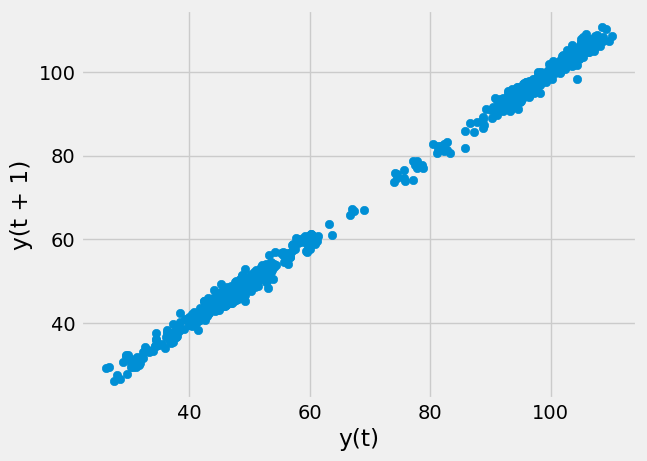

In [11]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

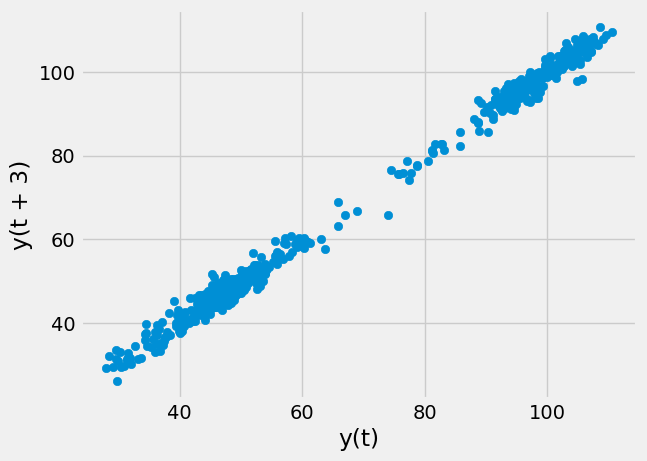

In [12]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 3)

There is very less correlation of prices with a 30 day gap between them

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 30)'>

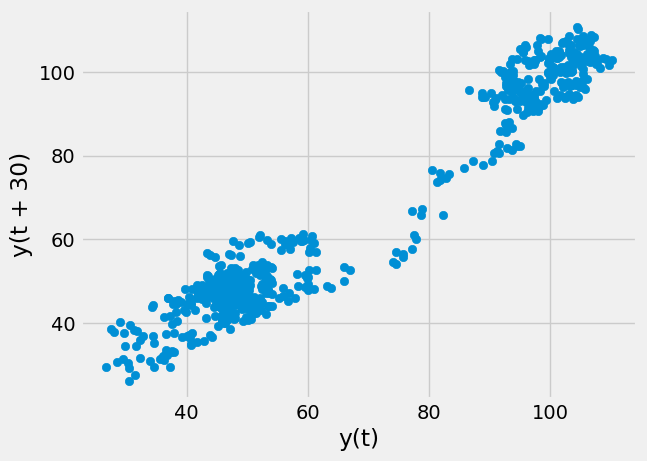

In [13]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 30)

Note : That the break in the linear spead of the data point is because the oil prices succently vary a lit in the 2014 to 2015 range

In [14]:
oil_df['dcoilwtico'][0] = oil_df['dcoilwtico'][1].copy()
oil_df = oil_df.interpolate(method='linear')

We have filled the missing values with linear interpolation.

In [15]:
fig = px.line(oil_df, x = oil_df.index, y ='dcoilwtico', title='Plot slider for oil prices')
fig.update_xaxes(
    rangeslider_visible = True,
)

# Plotting Sales vs various factors

In [16]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.set_index('date')

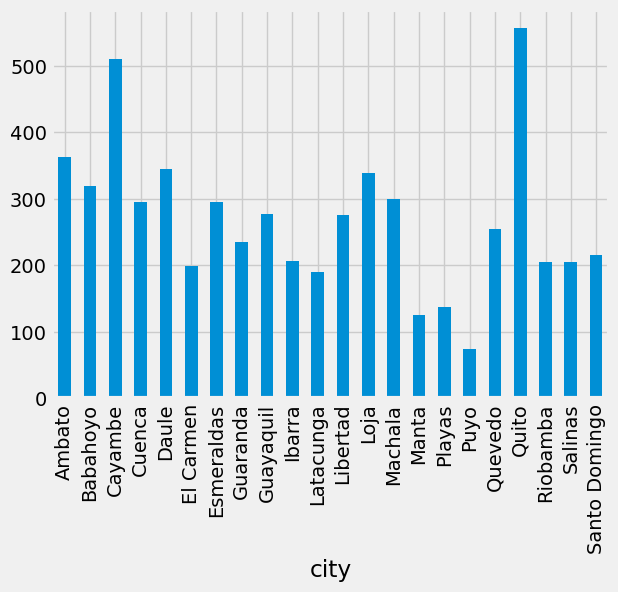

In [17]:
train_df.groupby(['city']).sales.mean().plot(kind='bar');

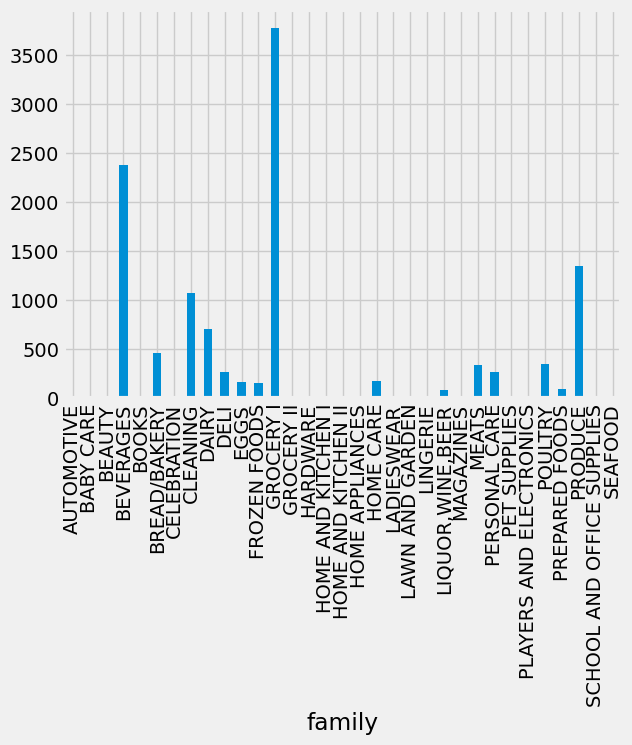

In [18]:
train_df.groupby(['family']).sales.mean().plot(kind='bar');

Text(0.5, 1.0, 'Promotion and Sales Relationship')

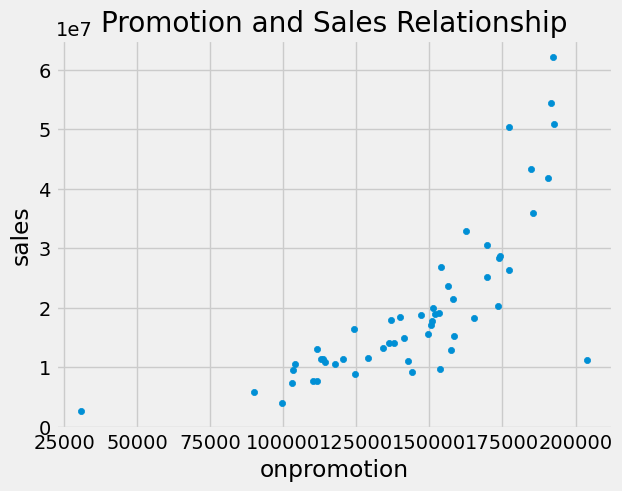

In [19]:
train_df.groupby('store_nbr')[['onpromotion','sales']].sum().plot.scatter('onpromotion','sales')
plt.title('Promotion and Sales Relationship')

# Merging oil prices with training data

In [20]:
train_df = pd.merge(train_df,oil_df,how='left',on='date')

In [21]:
print(train_df.query('dcoilwtico !=dcoilwtico'))

Empty DataFrame
Columns: [id, store_nbr, family, sales, onpromotion, city, state, type, cluster, dcoilwtico]
Index: []


As oil prices go down the Sales go up

In [22]:
grouped = train_df.groupby(['date']).agg({'dcoilwtico': 'mean', 'sales': 'mean'})
fig = px.line(grouped, x=grouped.index , y=['sales', 'dcoilwtico'])
fig.update_layout(title='Sale and Date Plot')
fig.show()
del grouped

In [23]:
train_df.head()

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
date,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14


# Preprocessing Holidays

In [24]:
holidays_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

holidays_df = holidays_df[holidays_df['transferred'] == False].copy()
holidays_df['holiday_type'] = holidays_df['type']
holidays_df.drop(['transferred', 'description', 'type'], axis=1, inplace=True)

national_holidays = holidays_df[holidays_df['locale'] == 'National'].copy()
national_holidays['national_holiday_type'] = national_holidays['holiday_type']
national_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)
national_holidays['date'] = pd.to_datetime(national_holidays['date'])
train_df = pd.merge(train_df, national_holidays, how='left', on=['date'])


# state_holidays = holidays_df[holidays_df['locale'] == 'Regional'].copy()
# state_holidays['state'] = state_holidays['locale_name']
# state_holidays['state_holiday_type'] = state_holidays['holiday_type']
# state_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
# state_holidays['date'] = pd.to_datetime(state_holidays['date'])
# train_df = pd.merge(train_df, state_holidays, how='left', on=['date', 'state'])

# city_holidays = holidays_df[holidays_df['locale'] == 'Local'].copy()
# city_holidays['city'] = city_holidays['locale_name']
# city_holidays['city_holiday_type'] = city_holidays['holiday_type']
# city_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
# city_holidays.drop([265], axis=0, inplace=True)
# city_holidays['date'] = pd.to_datetime(city_holidays['date'])
# train_df = pd.merge(train_df, city_holidays, how='left', on=['date', 'city'])

# del city_holidays
# del state_holidays
del national_holidays

train_df.head()

,date,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,national_holiday_type
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday
1,2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday
2,2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday
3,2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday
4,2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday


In [25]:
train_df.fillna('', inplace=True)

In [26]:
ordinal_encoder = OrdinalEncoder(dtype=int)
train_df[['family']] = ordinal_encoder.fit_transform(train_df[['family']])
train_df[['national_holiday_type']] = ordinal_encoder.fit_transform(train_df[['national_holiday_type']])
# train_df[['state_holiday_type']] = ordinal_encoder.fit_transform(train_df[['state_holiday_type']])
# train_df[['city_holiday_type']] = ordinal_encoder.fit_transform(train_df[['city_holiday_type']])

In [27]:
del train_df['city']
del train_df['state']
del train_df['type']
train_df.head()

,date,id,store_nbr,family,sales,onpromotion,cluster,dcoilwtico,national_holiday_type
0,2013-01-01,0,1,0,0.0,0,13,93.14,4
1,2013-01-01,1,1,1,0.0,0,13,93.14,4
2,2013-01-01,2,1,2,0.0,0,13,93.14,4
3,2013-01-01,3,1,3,0.0,0,13,93.14,4
4,2013-01-01,4,1,4,0.0,0,13,93.14,4


# Feature correlation

<AxesSubplot:>

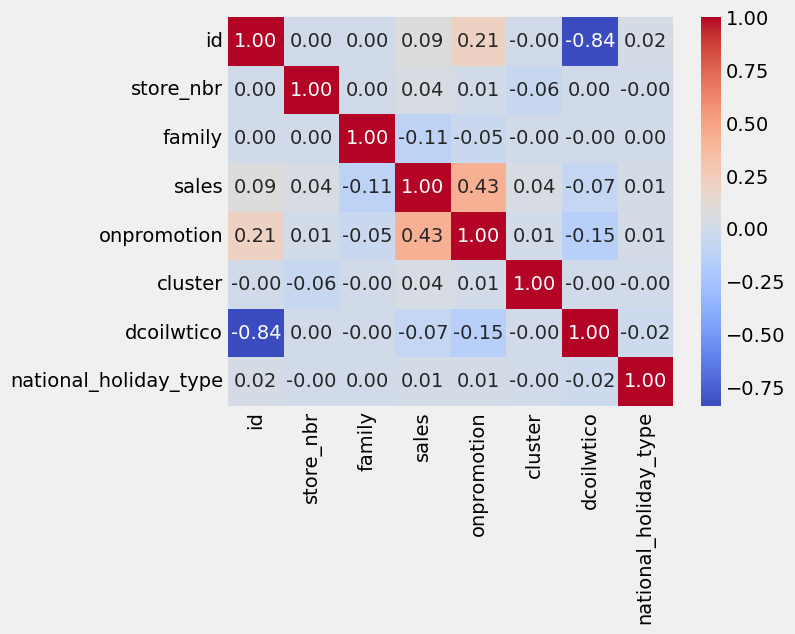

In [28]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = train_df.corr()

# Create a heatmap using seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Predicting Aggregate Sales Using XGBoost

In [29]:
grouped_df = train_df.groupby(['date']).agg({'sales': 'sum','dcoilwtico': 'mean', 
                                                 'onpromotion': 'sum',
                                                 'national_holiday_type': 'mean'})

grouped_df.head()

,sales,dcoilwtico,onpromotion,national_holiday_type
date,,,,
2013-01-01,2511.618999,93.140000,0,4.0
2013-01-02,496092.417944,93.140000,0,0.0
2013-01-03,361461.231124,92.970000,0,0.0
2013-01-04,354459.677093,93.120000,0,0.0
2013-01-05,477350.121229,93.146667,0,6.0


In [30]:
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

In [31]:
create_features(grouped_df)
grouped_df.head()

,sales,dcoilwtico,onpromotion,national_holiday_type,hour,dayofweek,quarter,month,year,dayofyear
date,,,,,,,,,,
2013-01-01,2511.618999,93.140000,0,4.0,0,1,1,1,2013,1
2013-01-02,496092.417944,93.140000,0,0.0,0,2,1,1,2013,2
2013-01-03,361461.231124,92.970000,0,0.0,0,3,1,1,2013,3
2013-01-04,354459.677093,93.120000,0,0.0,0,4,1,1,2013,4
2013-01-05,477350.121229,93.146667,0,6.0,0,5,1,1,2013,5


In [32]:
FEATURES = ['onpromotion','dcoilwtico', 'national_holiday_type', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']

TARGET = 'sales'

In [33]:
train = grouped_df.loc[grouped_df.index < '02-01-2017']
test = grouped_df.loc[grouped_df.index >= '02-01-2017']
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

**Using XGBoost**

In [34]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           max_depth=5,
                           learning_rate=0.05)

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

[0]	validation_0-rmse:618202.48533	validation_1-rmse:833172.58637
[100]	validation_0-rmse:55424.76579	validation_1-rmse:123135.86079
[200]	validation_0-rmse:36584.40305	validation_1-rmse:116855.65409
[300]	validation_0-rmse:28899.98982	validation_1-rmse:116169.17214
[400]	validation_0-rmse:23502.46501	validation_1-rmse:115407.51556
[500]	validation_0-rmse:19798.94840	validation_1-rmse:114132.51398
[600]	validation_0-rmse:17205.98573	validation_1-rmse:113337.47163
[700]	validation_0-rmse:14933.72850	validation_1-rmse:112857.03682
[800]	validation_0-rmse:12875.47610	validation_1-rmse:112496.50117
[900]	validation_0-rmse:11490.89957	validation_1-rmse:110621.38353
[1000]	validation_0-rmse:10332.20186	validation_1-rmse:109603.50331
[1100]	validation_0-rmse:9218.87350	validation_1-rmse:109042.77763
[1200]	validation_0-rmse:8417.25208	validation_1-rmse:107962.42461
[1300]	validation_0-rmse:7512.46741	validation_1-rmse:107739.23133
[1400]	validation_0-rmse:6848.97056	validation_1-rmse:107608.3

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [35]:
train = grouped_df[FEATURES]
grouped_df['predictions'] = reg.predict(train)

# Finding Feature Importance

<AxesSubplot:title={'center':'Feature Importance'}>

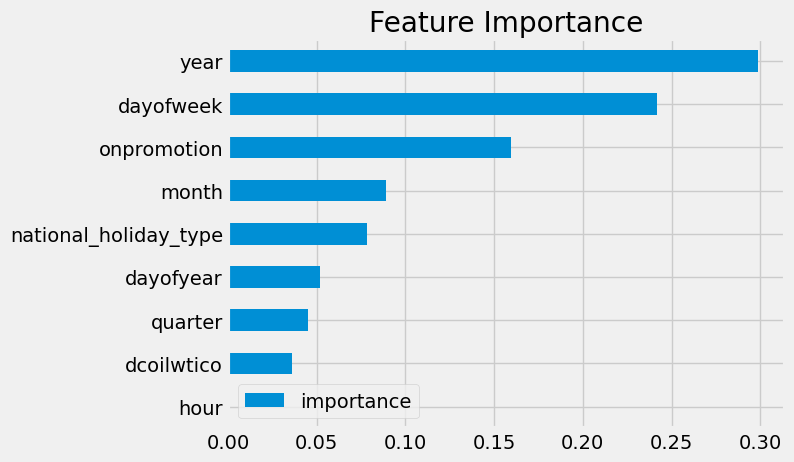

In [36]:
fi = pd.DataFrame(data= reg.feature_importances_,
             index = reg.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title ='Feature Importance')

In [37]:
fig = px.line(grouped_df, x=grouped_df.index , y=['sales', 'predictions'])
fig.update_layout(title='Sale and Date Plot')
fig.show()


[0]	validation_0-rmse:641.04490	validation_1-rmse:661.45157
[100]	validation_0-rmse:85.71834	validation_1-rmse:97.64188
[200]	validation_0-rmse:69.76583	validation_1-rmse:99.59689
[300]	validation_0-rmse:59.29784	validation_1-rmse:101.22472
[400]	validation_0-rmse:51.91683	validation_1-rmse:102.62841
[500]	validation_0-rmse:46.26908	validation_1-rmse:103.01200
[600]	validation_0-rmse:41.95925	validation_1-rmse:103.91753
[700]	validation_0-rmse:38.57569	validation_1-rmse:104.64988
[800]	validation_0-rmse:34.85952	validation_1-rmse:105.59504
[900]	validation_0-rmse:31.71191	validation_1-rmse:106.09244
[1000]	validation_0-rmse:29.38189	validation_1-rmse:106.75088
[1100]	validation_0-rmse:26.86385	validation_1-rmse:107.11004
[1200]	validation_0-rmse:25.02126	validation_1-rmse:107.27030
[1300]	validation_0-rmse:23.00811	validation_1-rmse:107.40299
[1400]	validation_0-rmse:21.49907	validation_1-rmse:107.73728
[1500]	validation_0-rmse:20.14272	validation_1-rmse:107.92886
[1600]	validation_0-r

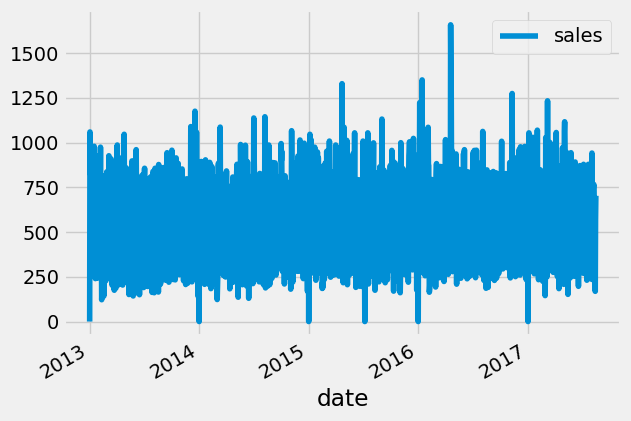

In [38]:
# for store in train_df['store_nbr'].unique():  
temp_df = train_df.query('store_nbr =='+str(1)+' and family==7')
temp_df = temp_df.set_index('date')
temp_df[['sales']].plot()

create_features(temp_df)

FEATURES = ['onpromotion','dcoilwtico', 'national_holiday_type', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']

TARGET = 'sales'

train = temp_df.loc[grouped_df.index < '02-01-2017']
test = temp_df.loc[grouped_df.index >= '02-01-2017']
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           max_depth=5,
                           learning_rate=0.05)

reg2.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

train = temp_df[FEATURES]
temp_df['predictions'] = reg2.predict(train)

fig = px.line(temp_df, x=grouped_df.index , y=['sales', 'predictions'])
fig.update_layout(title='Sale and Date Plot')
fig.show()

In [39]:
del grouped_df['predictions']
grouped_df.describe()

,sales,dcoilwtico,onpromotion,national_holiday_type,hour,dayofweek,quarter,month,year,dayofyear
count,1.684000e+03,1684.000000,1684.00000,1684.000000,1684.0,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000
mean,6.375564e+05,67.893530,4638.13658,0.248219,0.0,2.997031,2.410333,6.207838,2014.837886,173.388955
std,2.344102e+05,25.692307,5418.61702,0.914739,0.0,2.001334,1.100278,3.386673,1.345917,103.469470
min,2.511619e+03,26.190000,0.00000,0.000000,0.0,0.000000,1.000000,1.000000,2013.000000,1.000000
25%,4.427115e+05,46.378333,0.00000,0.000000,0.0,1.000000,1.000000,3.000000,2014.000000,85.000000
50%,6.321889e+05,53.301667,2300.00000,0.000000,0.0,3.000000,2.000000,6.000000,2015.000000,169.000000
75%,7.859455e+05,95.785000,8397.25000,0.000000,0.0,5.000000,3.000000,9.000000,2016.000000,259.250000
max,1.463084e+06,110.620000,26861.00000,6.000000,0.0,6.000000,4.000000,12.000000,2017.000000,366.000000


# Predicting Aggregate Sales Using LSTM

In [40]:
scaler  = MinMaxScaler()
scaled_grouped_df = scaler.fit_transform(grouped_df)
scaled_grouped_df.shape

(1684, 10)

In [41]:
features = scaled_grouped_df
target = scaled_grouped_df[:,0]

features.shape

(1684, 10)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state= 4, shuffle= False)

In [43]:
win_length = 50
batch_size = 32
input_features = X_train.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length =win_length,
                    sampling_rate =1, batch_size =batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length =win_length,
                    sampling_rate =1, batch_size =batch_size)

In [44]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(units=128, return_sequences=True,input_shape=[win_length, input_features]))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           71168     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 128)           0         
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [45]:
model.compile(loss= tf.losses.MeanSquaredError(),
             optimizer= tf.optimizers.Adam(),
             metrics =[tf.metrics.MeanAbsoluteError()])


history = model.fit(train_generator, epochs =50,
                              validation_data= test_generator,
                              shuffle = False)

Epoch 1/50
46/46 [==============================] - 17s 220ms/step - loss: 0.0309 - mean_absolute_error: 0.1421 - val_loss: 0.0136 - val_mean_absolute_error: 0.0904
Epoch 2/50
46/46 [==============================] - 9s 193ms/step - loss: 0.0185 - mean_absolute_error: 0.1044 - val_loss: 0.0252 - val_mean_absolute_error: 0.1174
Epoch 3/50
46/46 [==============================] - 9s 204ms/step - loss: 0.0210 - mean_absolute_error: 0.1148 - val_loss: 0.0295 - val_mean_absolute_error: 0.1313
Epoch 4/50
46/46 [==============================] - 8s 184ms/step - loss: 0.0180 - mean_absolute_error: 0.1051 - val_loss: 0.0212 - val_mean_absolute_error: 0.1036
Epoch 5/50
46/46 [==============================] - 9s 186ms/step - loss: 0.0177 - mean_absolute_error: 0.1055 - val_loss: 0.0195 - val_mean_absolute_error: 0.0981
Epoch 6/50
46/46 [==============================] - 9s 190ms/step - loss: 0.0171 - mean_absolute_error: 0.1030 - val_loss: 0.0205 - val_mean_absolute_error: 0.1014
Epoch 7/50
46/4

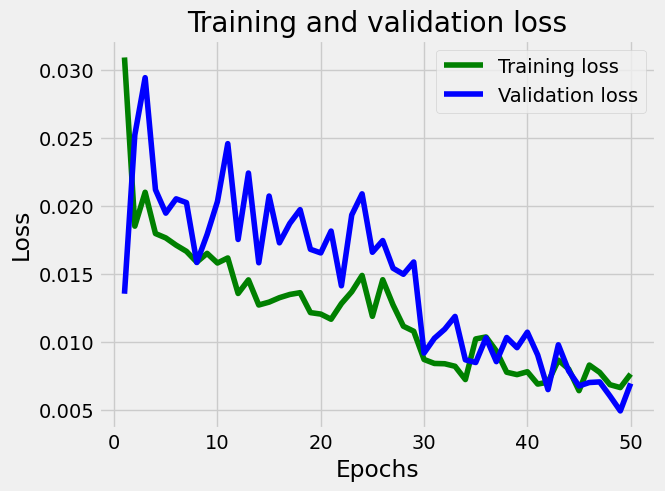

In [46]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss over epochs
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
model.evaluate(test_generator, verbose = 0)

[0.006971931084990501, 0.06096269190311432]

In [48]:
predictions = model.predict(test_generator)

4/4 [==============================] - 2s 60ms/step


In [49]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][win_length:])], axis = 1)
rev_trans = scaler.inverse_transform(df_pred)

In [50]:
df_final = grouped_df[predictions.shape[0]*-1:].copy()

In [51]:
df_final.count()

sales                    119
dcoilwtico               119
onpromotion              119
national_holiday_type    119
hour                     119
dayofweek                119
quarter                  119
month                    119
year                     119
dayofyear                119
dtype: int64

In [52]:
df_final['predictions'] = rev_trans[:,0]

<AxesSubplot:xlabel='date'>

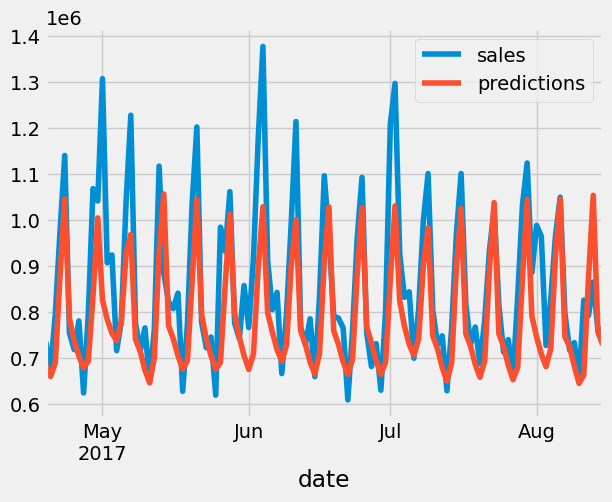

In [53]:
df_final[['sales','predictions']].plot()